In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [21]:
# Définition des noms fichiers, du path principal et de qques variables #

data_path = '/home/monteiro/STAGEIENM3/data_S2M/alp_flat/reanalysis/'

name_file_snow = 'snow_1958_2018.nc'
name_file_temp = 'Tair_1958_2018.nc'
name_file_meteo = 'Rainf_Snowf_1958_2018.nc'
name_file_metadata = 'others_dims_1958_2018.nc'

# Par région #

reg_NW = [1,2,3,4,5]
reg_North = [6,7,8,9,10,11,12]
reg_Central = [13,14]
reg_South = [15,16,17,18,19,20,21]
reg_Far_South = [22,23]
all_reg = [reg_NW,reg_North,reg_Central,reg_South,reg_Far_South]
all_reg_name = ['reg_NW','reg_North','reg_Central','reg_South','reg_Far_South']
range_ZS = np.arange(0,5100,300)

# Type d'altitude #
# Les tranche d'altitudes se font +- 150m

alt_plaine = [0,  300,  600] 
alt_basse = [900, 1200, 1500]
alt_moyenne = [1800, 2100, 2400, 2700]
alt_haute = [ 3000,3300, 3600, 3900, 4200, 4500, 4800]
range_ZS = [alt_plaine,alt_basse,alt_moyenne,alt_haute]
all_ZS = np.arange(0,5100,300)
range_ZS_name = [str(alt_plaine[0])+'-'+str(alt_plaine[-1]+150),str(alt_basse[0]-150)+'-'+str(alt_basse[-1]+150),str(alt_moyenne[0]-150)+'-'+str(alt_moyenne[-1]+150),str(alt_haute[0]-150)+'-'+str(alt_haute[-1])]

year = np.arange(1959,2019,1)

# Chargement des fichiers #

file_meteo = xr.open_dataset(data_path+name_file_meteo)
file_temp = xr.open_dataset(data_path+name_file_temp)
file_extra = xr.open_dataset(data_path+name_file_metadata)
file_extra = file_extra.isel(time=0)

In [16]:
#######################################################################################
### Extrait des subsets de l'espace et fais l'ecart type intra categories du subset ###
#######################################################################################

# Tenter de remplacer Number of points par une dim generique
# Remplacer egalement la fonction calc_ratio par generique

def data_per_x(data,sthg,ls_sthg,ls_sthg_name,data_extra): #STHG = string de la variable, data = wat u want, ls_sthg = valeur intra catégories(liste de listes), ls_sthg_name = Nom des catégorie
    
    data_per_x = []
    std_intra_x = []
    
    for i in range(0,len(ls_sthg)):
        ds_res = data.sel(Number_of_points = iextract(data_extra,sthg,ls_sthg[i])).mean(dim='Number_of_points')
        std = data.sel(Number_of_points = iextract(data_extra,sthg,ls_sthg[i])).std(dim='Number_of_points')
        data_per_x.append(ds_res)
        std_intra_x.append(std)

    data_per_x = xr.concat(data_per_x,dim = sthg)
    data_per_x[sthg] = ls_sthg_name
    std_intra_x = xr.concat(std_intra_x,dim =sthg)
    std_intra_x[sthg] = ls_sthg_name
    
    return std_intra_x,data_per_x

### Fonction extraction des indices ###

def iextract(data,variable,extract_list): # data = file_extra, variable = 'massif_number' or 'ZS', extract_list = Quelle liste/entier altitude ou de massif
    data = data[variable]
    iextract_list = []
    for i in range(0,len(data)):
        
        if type(extract_list) == int or type(extract_list) == np.int64 :
            if data[i].values == extract_list:
                iextract_list.append(i)
                
        else:
            for j in range(0,len(extract_list)):
                if data[i].values == extract_list[j]:
                    iextract_list.append(i)
    return iextract_list

In [1]:
##########################################################
# Calcul de la moyenne mensuelle/saisonniere ou annuelle #
##########################################################

# Cut automatically the first and last years as they r incomplete

def calc_mean(data,mean_type, skipna = True):
    
    ds_mean = []
    
    if mean_type == 'month':
        
        num_index = [9,10,11,12,1,2,3,4,5,6,7,8]
        ls_name = ['Sep', 'Oct','Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

        ds_res = data.resample(time='1MS').mean(skipna = skipna)
        
        for i in range(0,len(num_index)):
            ds_month = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_month = ds_month.groupby('time.year').mean('time',skipna = skipna)
            ds_mean.append(ds_month)
            
        ds_mean = xr.concat(ds_mean,dim='month')
        ds_mean = ds_mean.isel(year=slice(1,-1))
        ds_mean['month'] = ls_name

    if mean_type == 'season':
        
        num_index = [11,2,5,8]
        ls_name = ['SON','DJF','MAM','JJA']

        ds_res = data.resample(time='Q-FEB').mean(skipna = skipna)
        
        for i in range(0,len(num_index)):
            ds_season = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_season = ds_season.groupby('time.year').mean('time',skipna = skipna)
            ds_mean.append(ds_season)
       
        ds_mean = xr.concat(ds_mean,dim='season')
        ds_mean = ds_mean.isel(year=slice(1,-1))
        ds_mean['season'] = ls_name
        
    if mean_type == 'year':

        ds_mean = data.groupby('time.year').mean(skipna = skipna)
        ds_mean = ds_mean.isel(year = slice(1,-1))
    
    return ds_mean

In [18]:
#########################
### Fonction Calc_LPN ###
#########################

# -1 si pas de PR, -2 si au dessus du massif, -3 si en dessous le bas du massif

def calc_LPN(data,data_extra):
    
    ls_imassif = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,30]
    lpn = np.empty((len(data.time), len(ls_imassif)))

    for m in range(0,len(ls_imassif)):
        indflat = iextract(data_extra,'massif_number',ls_imassif[m])
        altitude = data_extra.ZS[indflat]
        rain_full = data.Rainf[:, indflat]
        snow_full = data.Snowf[:, indflat]
        phase = np.where(snow_full > 0, -1, np.where(rain_full > 0, 1, 0))
        lowestlevelindex = np.argmin(phase, axis=1)
        lpn_temp = altitude[lowestlevelindex] - 150
        lpn_temp = np.where(snow_full[:, 0] > 0., -3, lpn_temp)
        lpn_temp = np.where(rain_full[:, -1] > 0., -2, lpn_temp)
        lpn_temp = np.where(rain_full[:, -1] + snow_full[:, -1] < 1.E-8, -1, lpn_temp)

        lpn[:, m] = lpn_temp

    LPN = xr.Dataset({'lpn':(['time','massif'], lpn)},
                    coords = {'time' : data.time,
                             'massif': ls_imassif})
    LPN = LPN.lpn
    return LPN

#########################
### Fonction Calc_iso ###
#########################

def calc_isozero(data,data_extra):
    
    ls_imassif = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,30]
    isozero = np.empty((len(data.time), len(ls_imassif)))
    zero = 273.16
    tair = data.Tair
    
    for m in range(0,len(ls_imassif)):
        indflat = iextract(data_extra,'massif_number',ls_imassif[m])
        altitude = data_extra.ZS[indflat]

        zmax = np.max(altitude)
        tair_full = tair[:, indflat]
        tair_full_up = np.concatenate((tair_full[:,1:], np.zeros_like(tair_full[:,0:1]) + 999),axis=1)

        x = (tair_full * 100.).astype('int')  + tair_full_up / 1000.
        altipos = np.where(tair_full > zero, np.tile(altitude, (len(x[:,0]),1)) + x / 100000., -999.)
#ICI JAI CHANGE LALTITUDE PAR TILE(ALT)

        z = np.max(altipos, axis=1)
        y, zlow = np.modf(z)
        zup = zlow + 300
        ttempup,ttemplow = np.modf(y*100000)

        tlow=np.where(ttemplow > 0., ttemplow / 100., -999.) # Temperature of the level just below freezing level
        tup=np.where(ttempup > 0., ttempup * 1000., -998.) # Temperature of the level just above freezing level
        # Note that in cases of missing values, tup and tlow must be different to avoid a division by 0 just after

        # Freezing level is computed with a linear interpolation.
        isozero_temp = ((tlow - zero) * zup + (zero - tup) * zlow ) / (tlow - tup)
        isozero_temp = np.where(zlow == -999., -3, isozero_temp) # Freezing level below the lowest level
        isozero_temp = np.where(zlow == zmax.values, -2, isozero_temp) # Freezing level above the lowest level
        isozero[:, m] = isozero_temp

    isozero = xr.Dataset({'isozero':(['time','massif'], isozero)},
                    coords = {'time' : data.time,
                             'massif': ls_imassif})
    isozero = isozero.isozero
    return isozero


In [19]:
############################
### Calc min/max JJA/DJF ###
############################

# Data : data = f(season,years), sort or not in term of space
# CETTE FONCTION FAIT DE LA MERDE, ON A QUE UNE SEULE VALEUR PAR SAISON PAR AN


##########################
### LPN/iso per massif ###
##########################

def data_per_massif(data):

    data_per_massif = [] 

    for i in all_reg:
        data_per_massif.append(data.sel(massif = i).mean(dim = "massif"))
    
    data_per_massif = xr.concat(data_per_massif, dim = 'region')  
    data_per_massif['region'] = all_reg_name
    
    return data_per_massif


####################################
### Masquer les valeurs chiantes ###
####################################

def treat_LPN_ISO(data):

    data = data.where(data != -1)
    data = data.where(data != -2)
    data = data.where(data != -3)
    
    return data


#####################################
### Calcul des min/max saisonnier ###
#####################################


def min_max_per_season(data):
    
    min_per_season = []
    max_per_season = []

    for i in year:

        min_per_season.append(data.sel(time = str(i)).groupby('time.season').min())
        max_per_season.append(data.sel(time = str(i)).groupby('time.season').max())
    min_per_season = xr.concat(min_per_season, dim = 'year')
    max_per_season = xr.concat(max_per_season, dim = 'year')

    return min_per_season, max_per_season

In [22]:
### Calcul de la LPN/isozero moyenne ###

data = calc_LPN(file_meteo,file_extra)

data_treat = treat_LPN_ISO(data)
data_season = calc_mean(data_treat,'season')
data_month = calc_mean(data_treat,'month')
min_per_season, max_per_season = min_max_per_season(data_treat)

/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/monteiro/anacond

/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


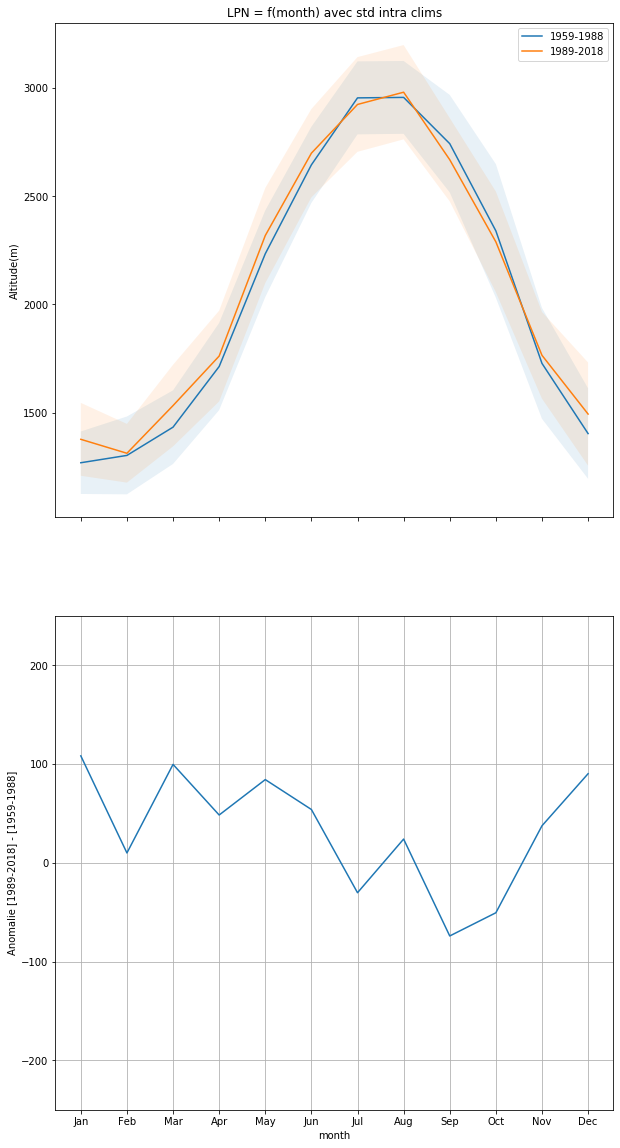

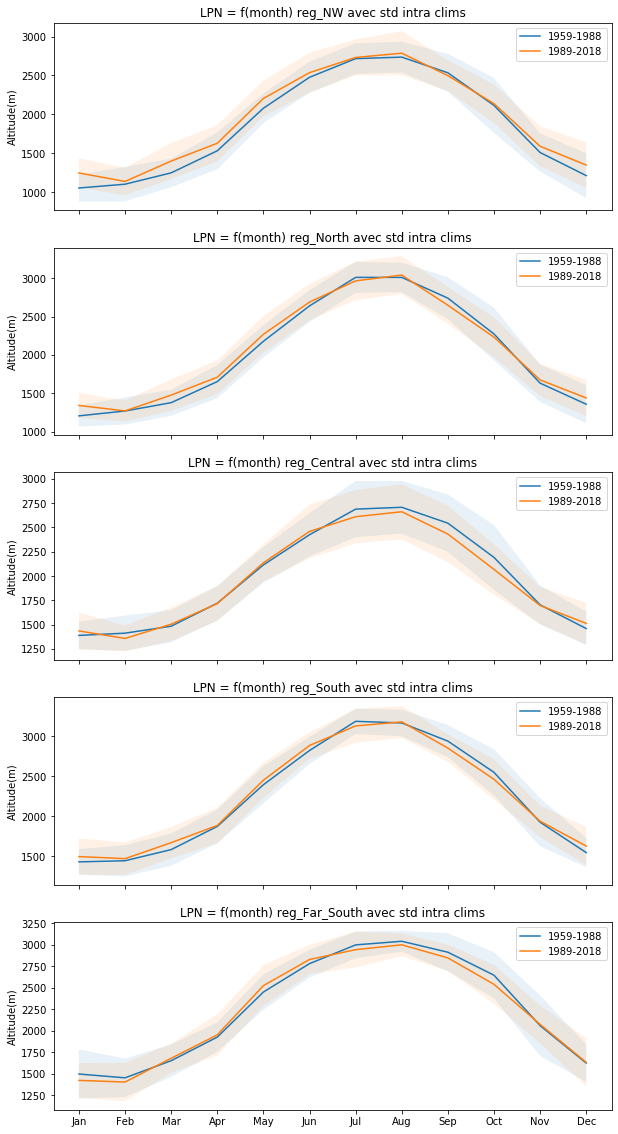

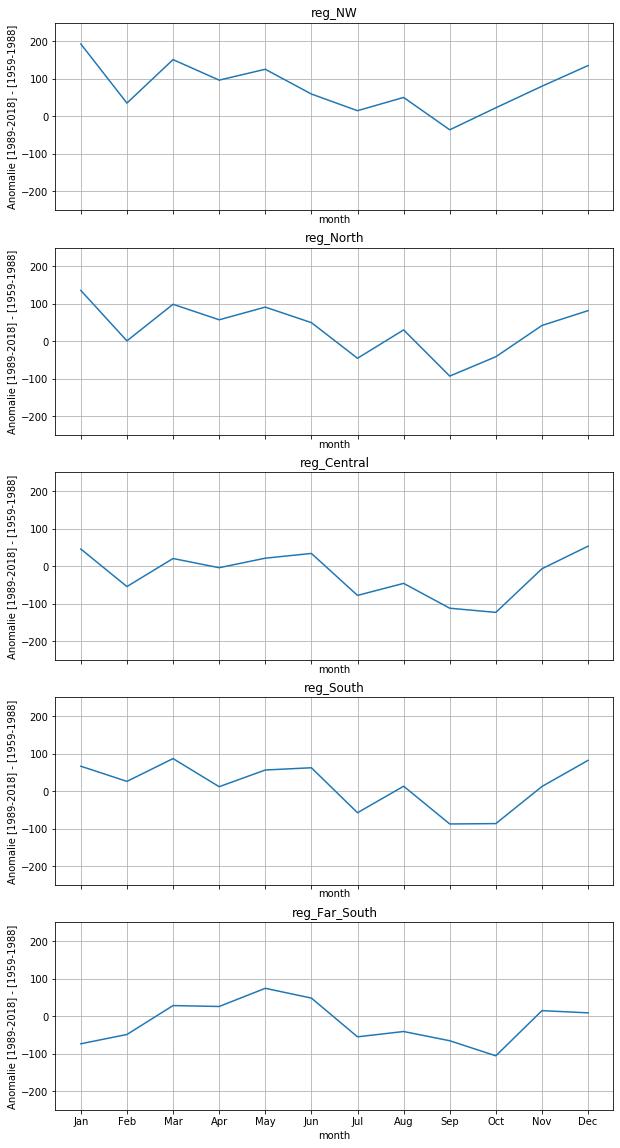

In [23]:
### PLOT LPN/isozero = f(month,clim) ###

# A faire pour chacune des régions 

yr_11,yr_12 = 1959,1988
yr_21,yr_22 = 1989,2018

fig, ax = plt.subplots(2, sharex='col', figsize=(10,20))

x1_mean = data_month.sel(year = slice(yr_11,yr_12)).mean(dim ='massif')
x1_std = x1_mean.std(dim='year')
x1_mean = x1_mean.mean(dim='year')

ax[0].plot(x1_mean.month,x1_mean,label=(str(yr_11)+'-'+str(yr_12)))

x2_mean = data_month.sel(year = slice(yr_21,yr_22)).mean(dim ='massif')
x2_std = x2_mean.std(dim='year')
x2_mean = x2_mean.mean(dim='year')

ax[0].plot(x2_mean.month,x2_mean,label=(str(yr_21)+'-'+str(yr_22)))
ax[0].legend()
ax[0].set(ylabel='Altitude(m)',
title= 'LPN = f(month) avec std intra clims')

ax[0].fill_between(x1_mean.month,
             x1_mean+x1_std,
             x1_mean-x1_std,
                   alpha = 0.1)
ax[0].fill_between(x2_mean.month,
             x2_mean+x2_std,
             x2_mean-x2_std,
            alpha = 0.1)


diff_clim = x2_mean - x1_mean
ax[1].plot(diff_clim.month, diff_clim)
ax[1].set_ylim(-250,250)
ax[1].grid()
ax[1].set(xlabel = ('month'), ylabel = 'Anomalie [1989-2018] - [1959-1988]')

############################################################################

fig, ax = plt.subplots(5, sharex='col', figsize=(10,20))
fig1, ax1 = plt.subplots(5, sharex='col', figsize=(10,20))


for j in range(0,len(all_reg_name)):

    x1_mean = data_month.sel(year = slice(yr_11,yr_12),massif = all_reg[j]).mean(dim ='massif')
    x1_std = x1_mean.std(dim='year')
    x1_mean = x1_mean.mean(dim='year')

    ax[j].plot(x1_mean.month,x1_mean,label=(str(yr_11)+'-'+str(yr_12)))

    x2_mean = data_month.sel(year = slice(yr_21,yr_22),massif = all_reg[j]).mean(dim ='massif')
    x2_std = x2_mean.std(dim='year')
    x2_mean = x2_mean.mean(dim='year')

    ax[j].plot(x2_mean.month,x2_mean,label=(str(yr_21)+'-'+str(yr_22)))
    ax[j].legend()
    ax[j].set(ylabel='Altitude(m)',
    title= 'LPN = f(month) '+str(all_reg_name[j])+' avec std intra clims')

    ax[j].fill_between(x1_mean.month,
                 x1_mean+x1_std,
                 x1_mean-x1_std,
                       alpha = 0.1)
    ax[j].fill_between(x2_mean.month,
                 x2_mean+x2_std,
                 x2_mean-x2_std,
                alpha = 0.1)

    diff_clim = x2_mean - x1_mean
    ax1[j].plot(diff_clim.month, diff_clim)
    ax1[j].set_ylim(-250,250)
    ax1[j].grid()
    ax1[j].set(xlabel = ('month'), ylabel = 'Anomalie [1989-2018] - [1959-1988]', title = str(all_reg_name[j]))


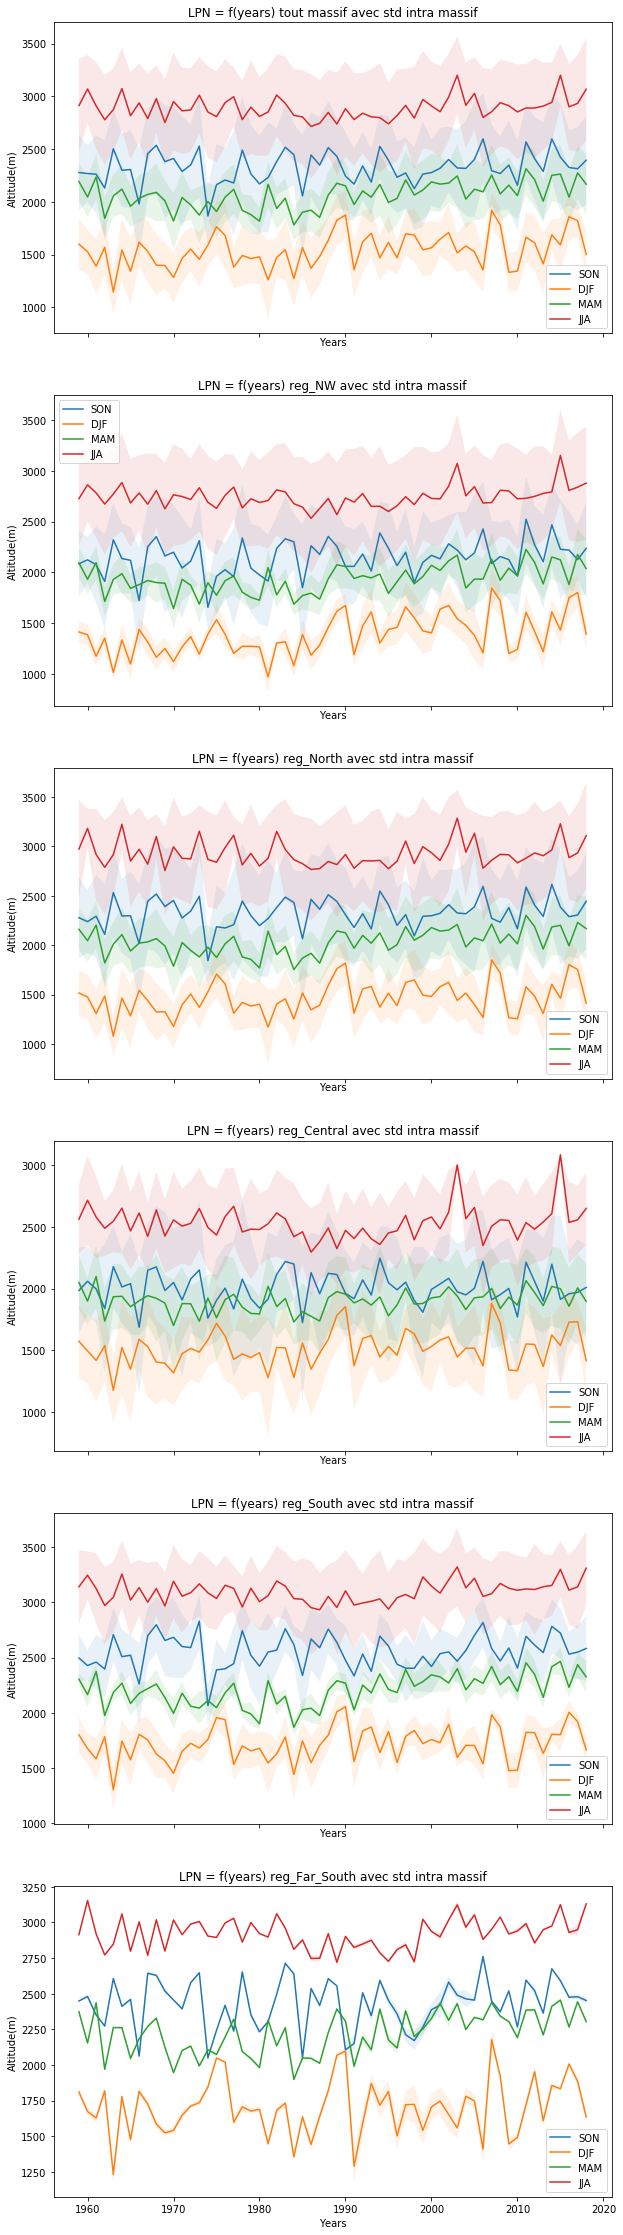

In [13]:
### PLOT LPN/isozero = f(years,season) ###

fig, ax = plt.subplots(6, sharex='col', figsize=(10,40))

for i in data_season.season:
    x_mean = data_season.sel(season=i).mean(dim ='massif')
    x_std = data_season.sel(season=i).std(dim ='massif')

    ax[0].plot(x_mean.year,x_mean, label = (str(i.values)))
    ax[0].legend()
    ax[0].set(ylabel='Altitude(m)',
    title= 'LPN = f(years) tout massif avec std intra massif',
          xlabel = 'Years')
    ax[0].fill_between(x_mean.year,
                 x_mean+x_std,
                 x_mean-x_std,
                alpha = 0.1)
    
for j in range(0,len(all_reg_name)):
    
    for i in data_season.season:
        x_mean = data_season.sel(season=i,massif = all_reg[j]).mean(dim ='massif')
        x_std = data_season.sel(season=i,massif = all_reg[j]).std(dim ='massif')

        ax[j+1].plot(x_mean.year,x_mean, label = (str(i.values)))
        ax[j+1].legend()
        ax[j+1].set(ylabel='Altitude(m)',
        title= 'LPN = f(years) '+str(all_reg_name[j])+' avec std intra massif',
              xlabel = 'Years')
        ax[j+1].fill_between(x_mean.year,
                     x_mean+x_std,
                     x_mean-x_std,
                    alpha = 0.1)

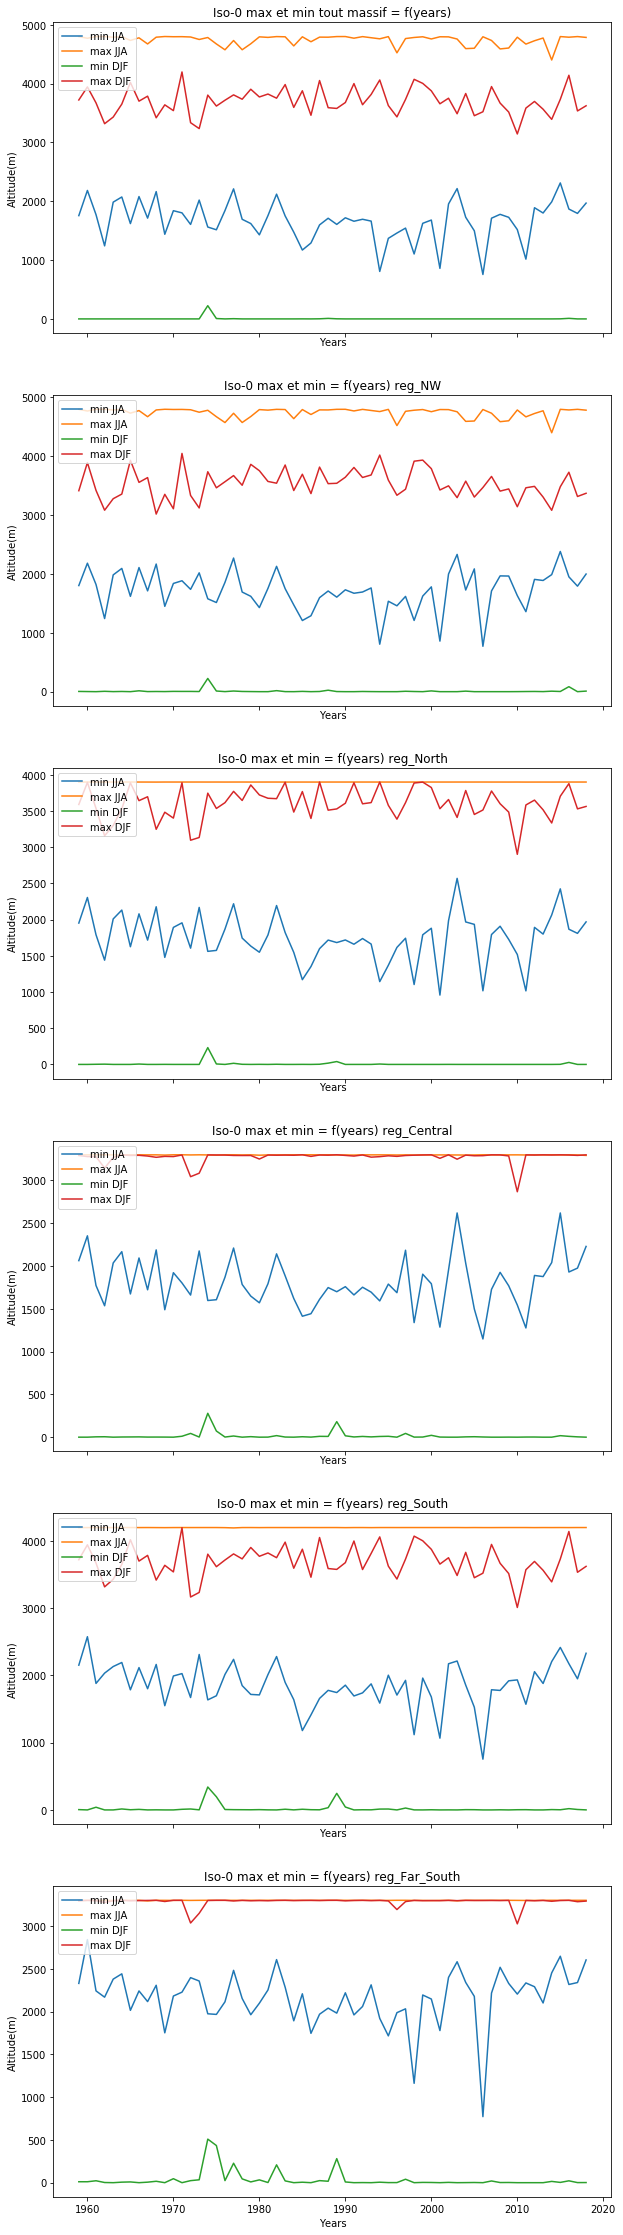

In [14]:
### Plot min/max saisonnier LPN/isozero ###

fig, ax = plt.subplots(6, sharex='col', figsize=(10,40))

x_min_JJA = min_per_season.sel(season = 'JJA').min(dim = 'massif')
x_max_JJA = max_per_season.sel(season = 'JJA').max(dim = 'massif')

x_min_DJF = min_per_season.sel(season = 'DJF').min(dim = 'massif')
x_max_DJF = max_per_season.sel(season = 'DJF').max(dim = 'massif')

ax[0].plot(year,x_min_JJA, label = ('min '+str(x_min_JJA.season.values)))
ax[0].plot(year,x_max_JJA, label = ('max '+str(x_max_JJA.season.values)))  
ax[0].plot(year,x_min_DJF, label = ('min '+str(x_min_DJF.season.values)))
ax[0].plot(year,x_max_DJF, label = ('max '+str(x_max_DJF.season.values)))
ax[0].legend(loc = 'upper left')
ax[0].set(ylabel='Altitude(m)',title= ('Iso-0 max et min tout massif = f(years)'), xlabel = 'Years')

for j in range(0,len(all_reg_name)):
    x_min_JJA = min_per_season.sel(season = 'JJA', massif = all_reg[j]).min(dim = 'massif')
    x_max_JJA = max_per_season.sel(season = 'JJA', massif = all_reg[j]).max(dim = 'massif')

    x_min_DJF = min_per_season.sel(season = 'DJF', massif = all_reg[j]).min(dim = 'massif')
    x_max_DJF = max_per_season.sel(season = 'DJF', massif = all_reg[j]).max(dim = 'massif')


    ax[j+1].plot(year,x_min_JJA, label = ('min '+str(x_min_JJA.season.values)))
    ax[j+1].plot(year,x_max_JJA, label = ('max '+str(x_max_JJA.season.values)))  
    ax[j+1].plot(year,x_min_DJF, label = ('min '+str(x_min_DJF.season.values)))
    ax[j+1].plot(year,x_max_DJF, label = ('max '+str(x_max_DJF.season.values)))
    ax[j+1].legend(loc = 'upper left')
    ax[j+1].set(ylabel='Altitude(m)',
    title= ('Iso-0 max et min = f(years) '+all_reg_name[j]),
          xlabel = 'Years')